In [1]:
# import packages
%pylab inline

import xarray as xr
import pandas as pd

import os

#import statsmodels.api as sm
#import statsmodels.formula.api as smf

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.util import add_cyclic_point

import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import colorbar, colors

import numpy as np
from scipy.stats import poisson
import numpy as np

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation
# detrending and putting back mask
from scipy.signal import detrend

import random
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
import regionmask

from scipy.stats import linregress

import sys
wython = '/tigress/wenchang/wython'
if wython not in sys.path: sys.path.append(wython)
from xtc import wherebasin

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# some configurations on the default figure output
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.dpi'] = 120

In [22]:
# Define bounding box
lat_min, lat_max = 0, 60
lon_min, lon_max = 240, 360

# Create a mask where lat and lon fall within the bounding box
mask = (
    (ds.lat >= lat_min) & (ds.lat <= lat_max) &
    (ds.lon >= lon_min) & (ds.lon <= lon_max)
)

# Apply mask to all variables — where the condition is False, values become NaN
ds_atl = ds.where(mask, drop=False)  # drop=False keeps full shape with NaNs


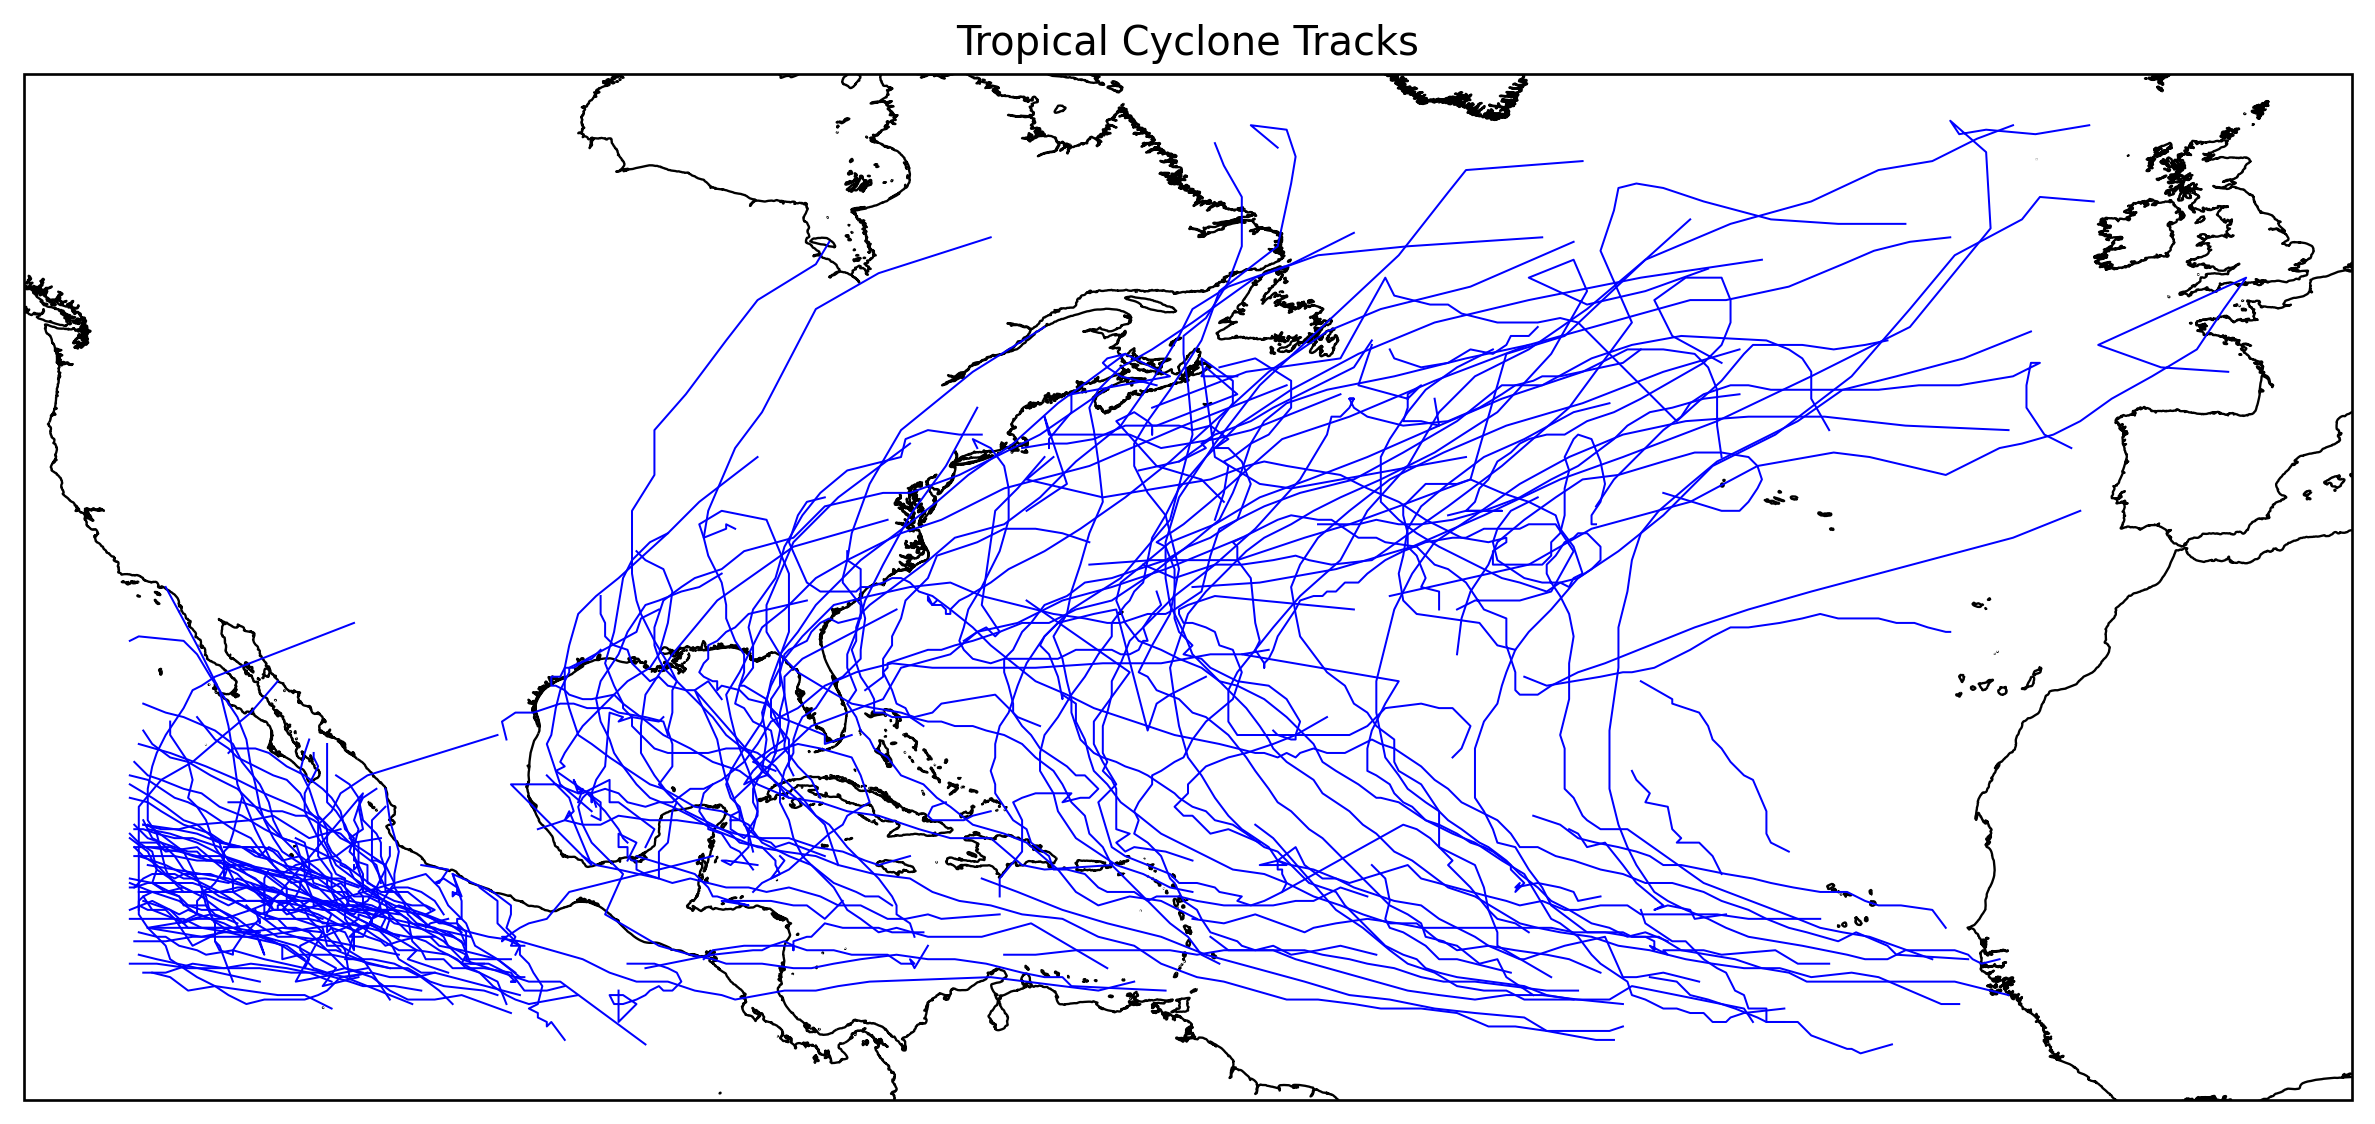

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create figure and map projection
fig, ax = plt.subplots(figsize=(10, 8),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Add base map features
ax.coastlines(resolution='10m', linewidth=0.7)

import numpy as np

for y in ds_atl.year_final:
    for s in ds_atl.storm:
        lon = ds_atl.lon.sel(year_final=y, storm=s).values
        lat = ds_atl.lat.sel(year_final=y, storm=s).values

        # Mask NaNs
        valid = (~np.isnan(lon)) & (~np.isnan(lat))
        if valid.any():
            ax.plot(lon[valid], lat[valid], color='blue', linewidth=0.6,
                    transform=ccrs.PlateCarree())

plt.title('Tropical Cyclone Tracks')
plt.tight_layout()
plt.show()


Plotted a storm
Plotted a storm
Plotted a storm
Plotted a storm
Plotted a storm
Plotted a storm
Plotted a storm


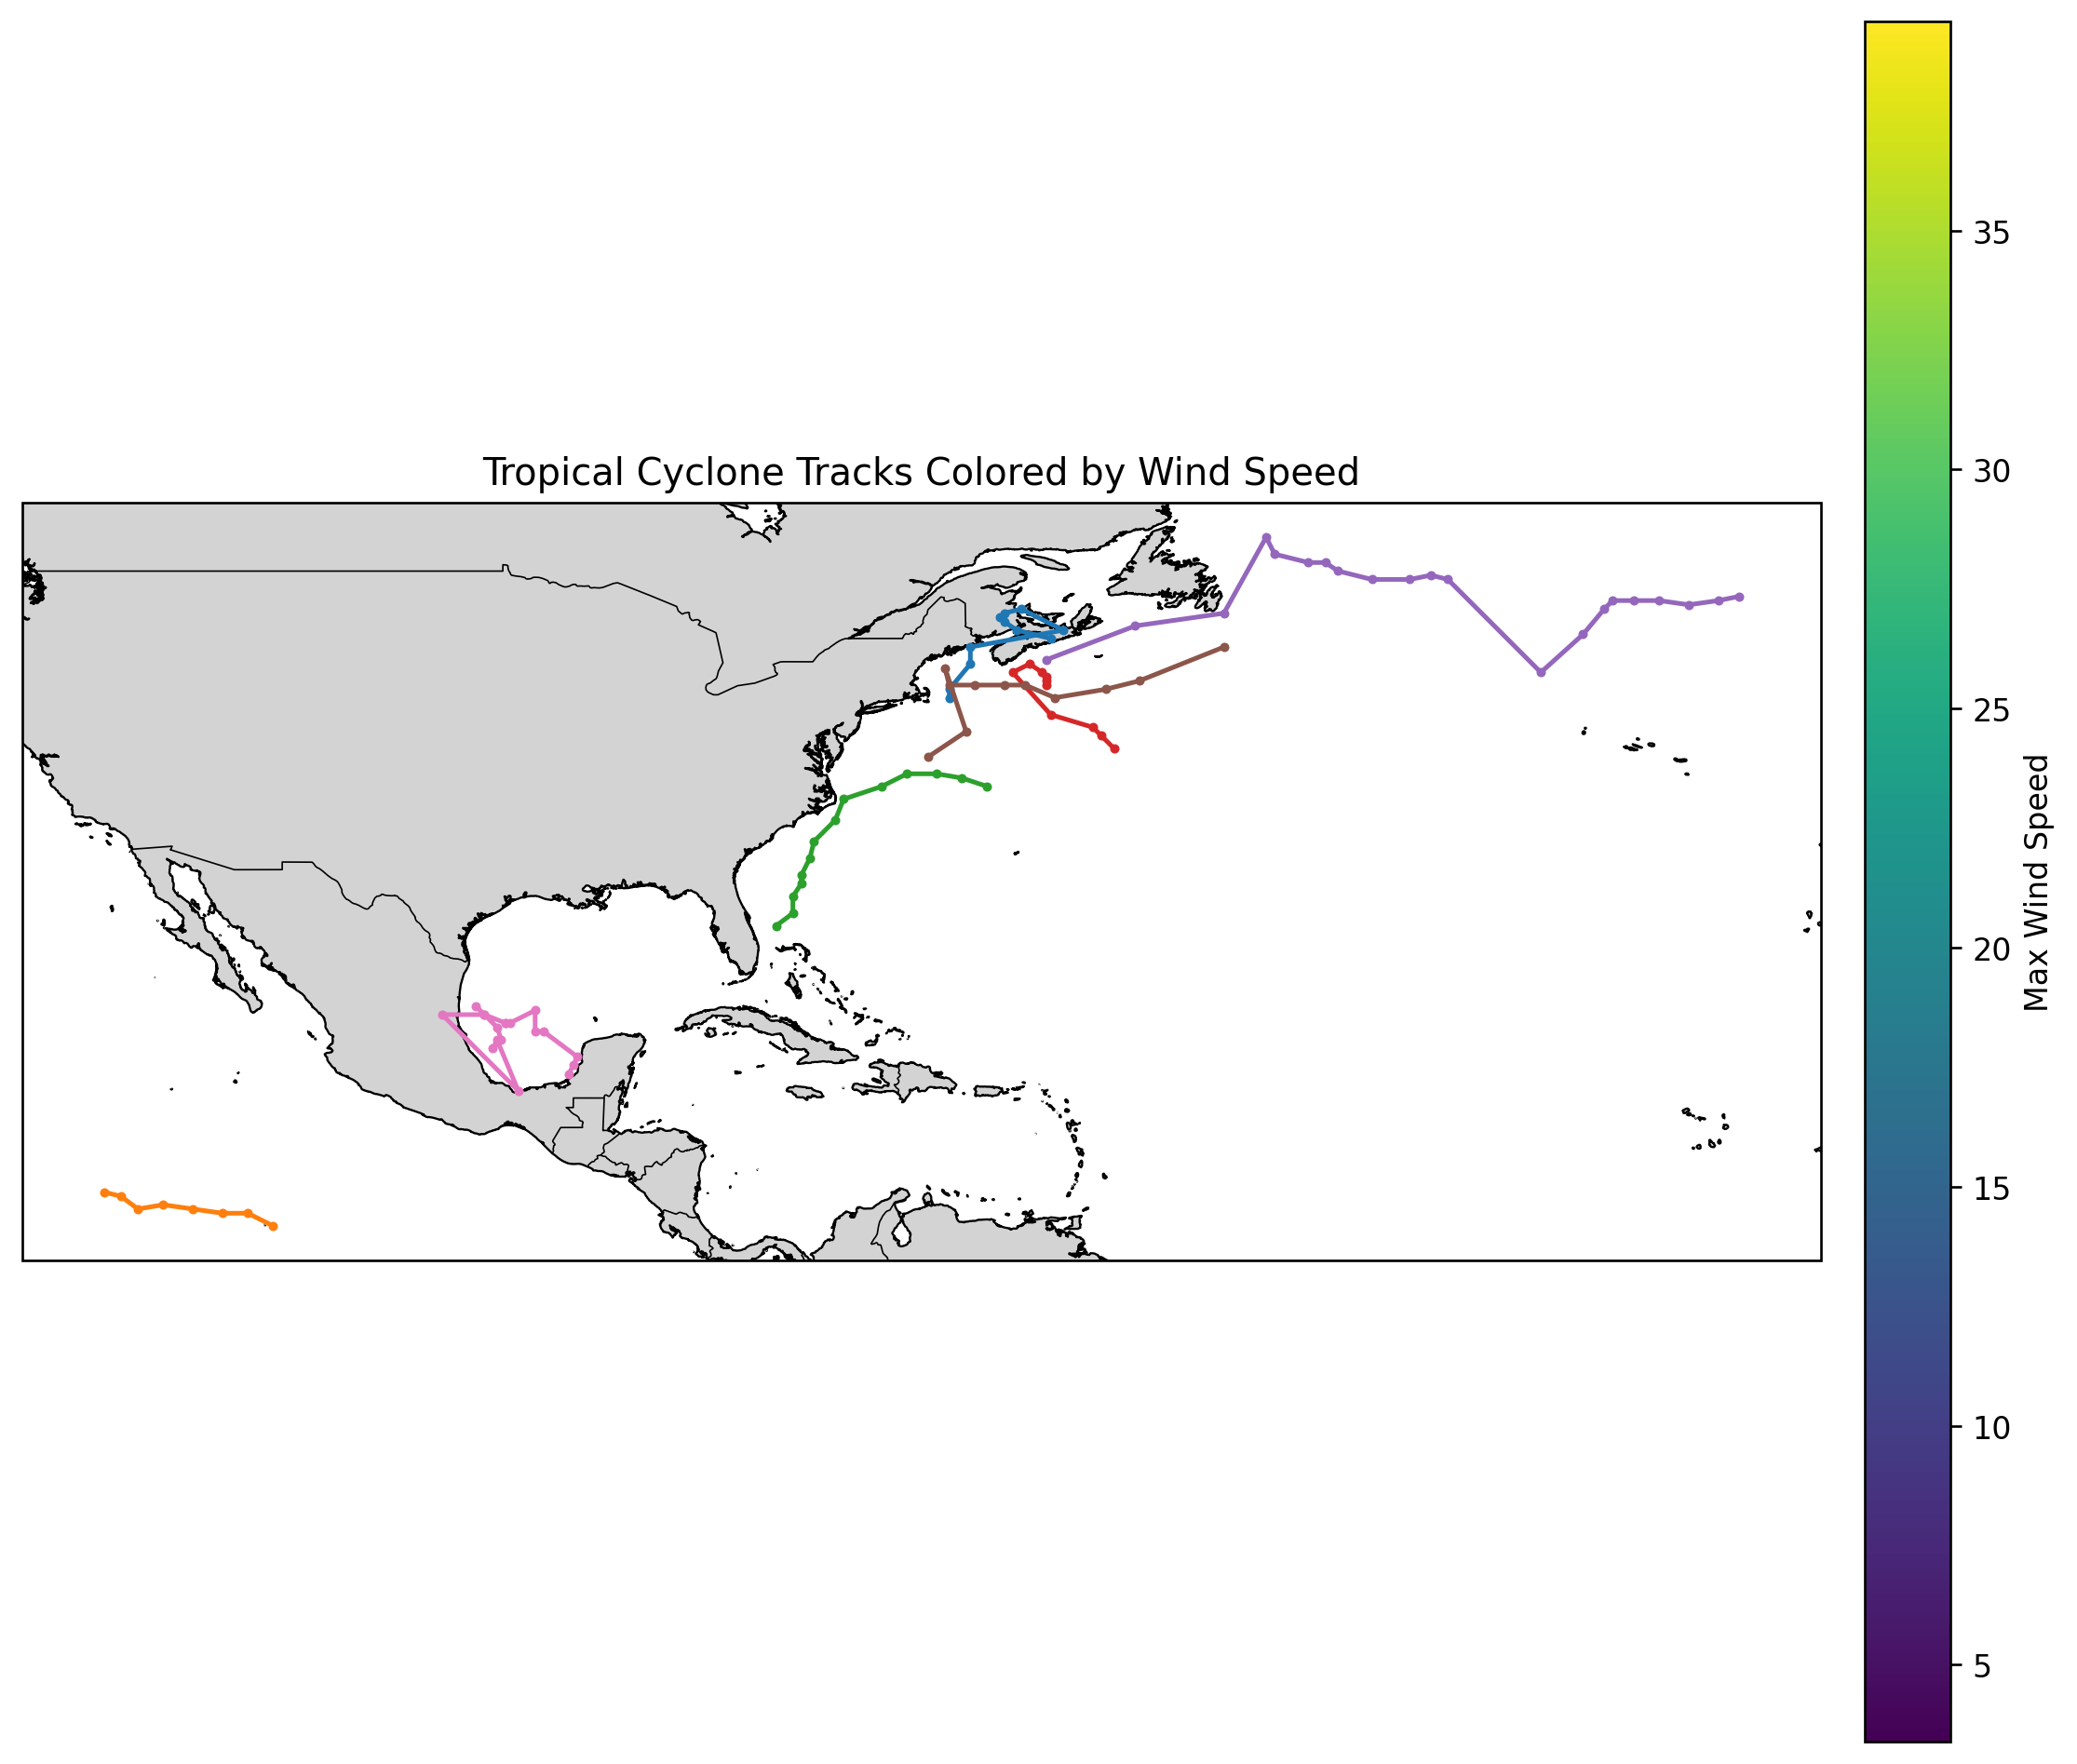

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import numpy as np

# Create figure and map projection
fig, ax = plt.subplots(figsize=(10, 8),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Add base map features
ax.coastlines(resolution='10m', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Define colormap and normalization for windmax
vmin = float(ds_atl.windmax.min())
vmax = float(ds_atl.windmax.max())
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Loop through all storms
for y in ds_atl.year_final:
    for s in ds_atl.storm:
        lon = ds_atl.lon.sel(year_final=y, storm=s).values
        lat = ds_atl.lat.sel(year_final=y, storm=s).values
        wind = ds_atl.windmax.sel(year_final=y, storm=s).values

        # Remove NaNs
        valid = (~np.isnan(lon)) & (~np.isnan(lat)) & (~np.isnan(wind))
        lon, lat, wind = lon[valid], lat[valid], wind[valid]

        # Only plot if at least 2 valid points
        '''if len(lon) > 1:
            # Create line segments and corresponding wind speed values
            points = np.array([lon, lat]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            wind_seg = (wind[:-1] + wind[1:]) / 2  # average wind for each segment

            lc = LineCollection(segments, cmap=cmap, norm=norm,
                                array=wind_seg, linewidth=1.2,
                                transform=ccrs.PlateCarree())

            ax.add_collection(lc) '''
        if len(lon) > 1:
            ax.plot(lon, lat, marker='o', markersize=2, transform=ccrs.PlateCarree())
            print("Plotted a storm")
            break  # only plot one for testing
# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Max Wind Speed')

# Final touches
plt.title('Tropical Cyclone Tracks Colored by Wind Speed')
plt.tight_layout()
plt.show()


In [3]:
import xarray as xr, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.collections import LineCollection
from geoplots import mapplot

def single_track_plot(lonvec, latvec, vmvec, ax=None, lw=1, alpha=1):
    '''plot TC a TC track with varied colors indicating wind spead.'''
    if ax is None:
        ax = plt.gca()
    
    # create segments for the LineCollection
    L = ~np.isnan(lonvec)
    x = lonvec[L]
    y = latvec[L]
    vm = vmvec[L]
    vm = (vm[:-1] + vm[1:])/2.0
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # colormap from: 
    # https://upload.wikimedia.org/wikipedia/commons/6/6f/Tropical_cyclones_1945_2006_wikicolor.png
    c = ListedColormap(np.array([(114, 185, 249),
                                (122, 246, 244),
                                (255, 254, 209),
                                (252, 231, 134),
                                (247, 195, 90),
                                (241, 148, 64),
                                (238, 107, 103)])/255.0 )
    levels = [0, 18, 33, 43, 50, 58 , 70, 100]
    norm = BoundaryNorm(levels, c.N)
    
    # LineCollection objects
    lc = LineCollection(segments, cmap=c, norm=norm)
    lc.set_array(vm)
    lc.set_linewidth(lw)
    lc.set_alpha(alpha)

    lines = ax.add_collection(lc)
    ax.autoscale()
    
    return lines

There are some problems for the deprecated basemap package.


In [4]:
def trackplot(ds, **kwargs):
    '''plot TC a TC track with varied colors indicating wind spead.
    kwargs include: 
        ax(=plt.gca()), 
        lw(=0.5), 
        alpha(=0.5). 
        
    **usage**
        lines = trackplot(ds.isel(year=slice(0,10)), alpha=1)
        plt.colorbar(lines.isel(year=0, storm=0).item())
    '''    
    lines = xr.apply_ufunc(single_track_plot,
                          ds.lon, ds.lat, ds.windmax,
                          input_core_dims=[['stage'], ['stage'], ['stage']],
                          vectorize=True,
                          kwargs=kwargs)
    ax = kwargs.pop('ax', plt.gca())
    ax.autoscale()
    
    return lines

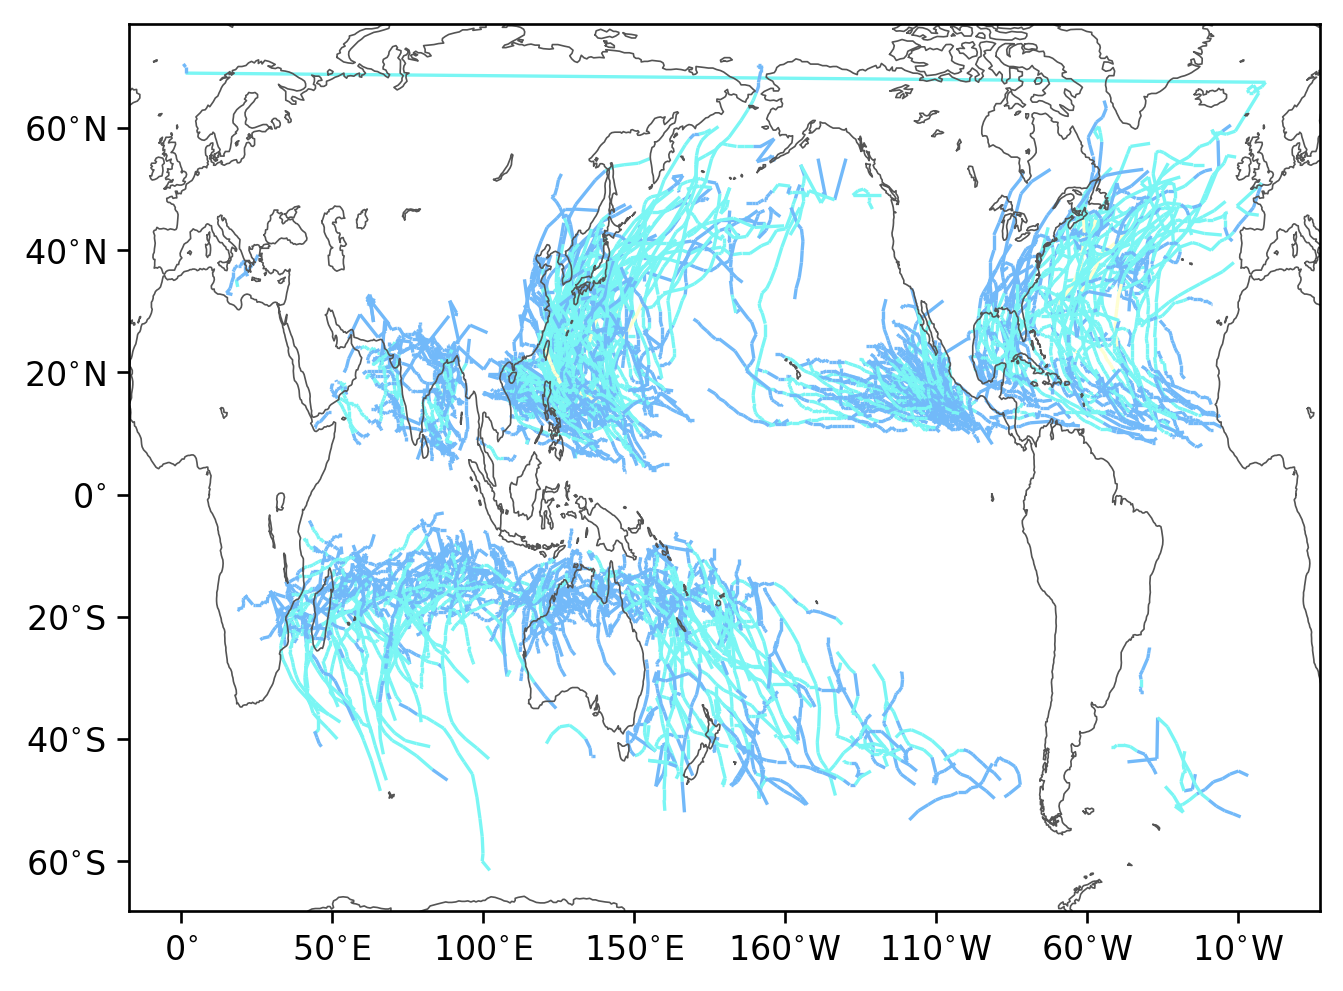

In [8]:
ds.pipe(trackplot)
mapplot()

In [6]:

ds = xr.open_dataset("/home/el2358/GEOCLIM/el2358/projects/tc_tracker/stitch_data_output/era5_tc_tracks_2018_2024.nc")

#ds_atl = ds.sel(lat=slice(0,60)).sel(lon=slice(120,350))

In [8]:
ds.lon.values

array([[[ 61.  ,  58.75,  57.  , ...,    nan,    nan,    nan],
        [ 95.75,  96.75,  94.75, ...,    nan,    nan,    nan],
        [171.75, 172.75, 174.  , ...,    nan,    nan,    nan],
        ...,
        [ 57.  ,  57.75,  57.75, ...,    nan,    nan,    nan],
        [142.  , 137.75, 137.25, ...,    nan,    nan,    nan],
        [145.5 , 144.75, 144.75, ...,    nan,    nan,    nan]],

       [[110.75, 110.25, 109.75, ...,    nan,    nan,    nan],
        [141.  , 142.  , 142.75, ...,    nan,    nan,    nan],
        [175.  , 177.25, 176.25, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[ 59.5 ,  60.25,  61.25, ...,    nan,    nan,    nan],
        [121.25, 121.  , 121.5 , ...,    nan,    nan,    nan],
        [129.5 , 128.5 , 127.25, ...,    nan,    nan,    nan],
        ...,
        [   

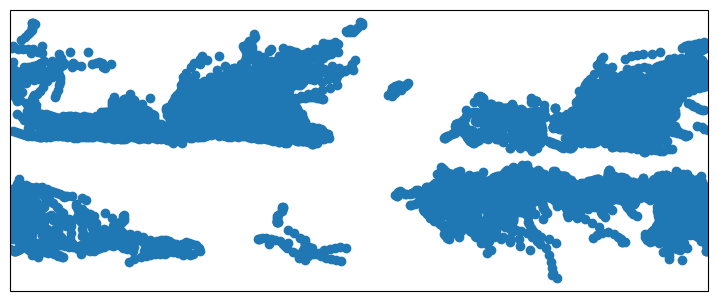

In [5]:
# Set up subplots with PlateCarree projection
fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(9, 8.5))

plt.scatter(ds.lon, ds.lat, transform=ccrs.PlateCarree())


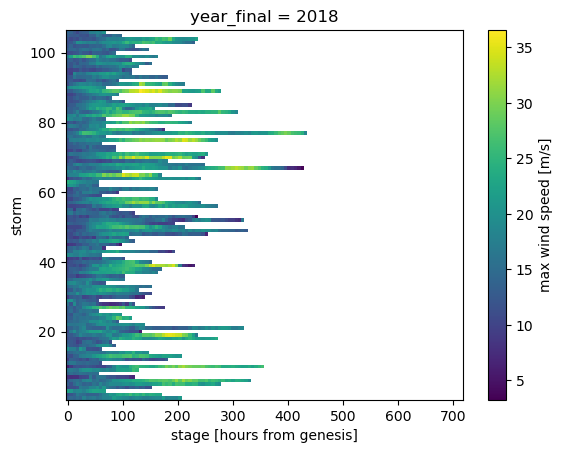

In [12]:
ds.isel(year_final=0).windmax.plot()

In [7]:
ds.storm

<xarray.DataArray 'storm' (storm: 106)> Size: 848B
array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106])
Coordinates:
  * storm    (storm) int64 848B 1 2 3 4 5 6 7 8 ... 100 101 102 103 104 105 106

/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)


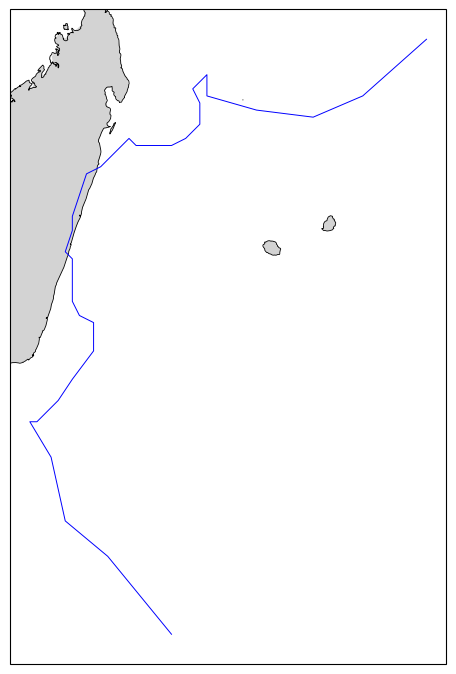

In [4]:


lon = ds.lon.isel(storm=0).isel(year_final=0)
lat = ds.lat.isel(storm=0).isel(year_final=0)

fig, ax = plt.subplots(figsize=(9, 8.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and land features
ax.coastlines(resolution='10m', linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

ax.plot(lon, lat, transform=ccrs.PlateCarree(), linewidth=0.7, color='blue')

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(9, 8.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and land features
ax.coastlines(resolution='10m', linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# If storms are distinguished by an ID (e.g., 'storm_id' coordinate)
for storm_id in ds.storm.values:
    lon = ds.lon.sel(storm=storm_id)
    lat = ds.lat.sel(storm=storm_id)
    ax.plot(lon, lat, transform=ccrs.PlateCarree(), linewidth=0.7, color='blue')

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

plt.title('Tropical Cyclone Tracks')
plt.show()


/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/home/GEOC